<a href="https://colab.research.google.com/github/pam-lab/JupyterFiles/blob/main/NLP_HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf

In [2]:
!pip install -Uqq transformers
!pip install -Uqq hazm
!pip install -Uqq datasets
!pip install -Uqq seqeval

     |████████████████████████████████| 4.7 MB 32.1 MB/s 
     |████████████████████████████████| 6.6 MB 6.2 MB/s 
     |████████████████████████████████| 596 kB 44.9 MB/s 
     |████████████████████████████████| 101 kB 12.7 MB/s 
     |████████████████████████████████| 316 kB 8.4 MB/s 
     |████████████████████████████████| 1.4 MB 48.0 MB/s 
     |████████████████████████████████| 233 kB 11.0 MB/s 
     |████████████████████████████████| 365 kB 32.4 MB/s 
     |████████████████████████████████| 141 kB 65.2 MB/s 
     |████████████████████████████████| 212 kB 60.8 MB/s 
     |████████████████████████████████| 127 kB 68.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 43 kB 1.9 MB/s 


In [3]:
import numpy as np
import pandas as pd

import hazm

import transformers 
from transformers import AutoTokenizer, AutoConfig
from transformers import TFAutoModelForTokenClassification
import itertools
from datasets import Dataset
from datasets import load_metric
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification


import os
import itertools
import pandas as pd
import numpy as np
from datasets import Dataset
from datasets import load_metric
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
import torch

import os
from IPython.display import display, HTML, clear_output
from ipywidgets import widgets, Layout

print()
print('tensorflow', tf.__version__)
print('transformers', transformers.__version__)
print('numpy', np.__version__)
print('pandas', pd.__version__)
print()

if tf.test.gpu_device_name() != '/device:GPU:0':
    print()
    print('WARNING: GPU device not found.')
else:
    print()
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))


tensorflow 2.8.2
transformers 4.21.0
numpy 1.21.6
pandas 1.3.5


SUCCESS: Found GPU: /device:GPU:0


### Fine-tune model with our data

In [4]:
!gdown 1oJjoGK15-RD7IHm8-k0DhSXFlWDaq201
!gdown 1AzXg9YVaXCAzalr57IpP1sNbWBBbZrqI
!gdown 1LXZrlNFr8jKhVF5ETEu6OwnuwPfrIyLw

Downloading...
From: https://drive.google.com/uc?id=1oJjoGK15-RD7IHm8-k0DhSXFlWDaq201
To: /content/ner-train.csv
100% 6.85M/6.85M [00:00<00:00, 179MB/s]
Downloading...
From: https://drive.google.com/uc?id=1AzXg9YVaXCAzalr57IpP1sNbWBBbZrqI
To: /content/ner-test.csv
100% 383k/383k [00:00<00:00, 87.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1LXZrlNFr8jKhVF5ETEu6OwnuwPfrIyLw
To: /content/ner-eval.csv
100% 348k/348k [00:00<00:00, 44.0MB/s]


In [5]:
data_train = pd.read_csv('ner-train.csv')
data_val = pd.read_csv('ner-eval.csv')
data_test = pd.read_csv('ner-test.csv')

In [6]:
len(data_train), len(data_val), len(data_test)

(4050, 225, 225)

In [7]:
def clean_alt_list(list_):
    list_ = list_.replace('[','').replace(']','').split(',')
    return [item.replace("'","").strip() for item in list_]

In [8]:
def convert_to_list(data):
    data['token'] = data['token'].apply(clean_alt_list)
    data['labels'] = data['labels'].apply(clean_alt_list)

In [9]:
convert_to_list(data_train)
convert_to_list(data_val)
convert_to_list(data_test)

In [10]:
data_train

,token,labels
0,"[«صندلی, داغ», و, «شب, آرام», در, نوروزی, های,...","[o, o, o, o, o, o, B-DAT, I-DAT, o, o]"
1,"[به, گزارش, خبرگزاری, مهر, به, نقل, از, روابط,...","[o, o, B-ORG, I-ORG, I-ORG, o, o, B-ORG, I-ORG..."
2,"[به, گزارش, خبرگزاری, مهر, به, نقل, از, روابط,...","[o, o, B-ORG, I-ORG, I-ORG, o, o, B-ORG, I-ORG..."
3,"[نشان, درجه, یک, هنری, استاد, «محمدرضا, اسحاقی...","[o, o, o, o, o, o, B-PER, o, o, o, o, o, o, o, o]"
4,"[به, گزارش, خبرنگار, خبرگزاری, شبستان, مازندرا...","[o, o, o, B-ORG, I-ORG, I-ORG, o, B-LOC, o, B-..."
...,...,...
4045,"[اگر, این, تحریم, ها, موجب, تضعیف, اقتصاد, روس...","[o, o, o, o, o, o, o, o, o, o, o, o, o, o, o, ..."
4046,"[اگر, این, تحریم, ها, موجب, تضعیف, اقتصاد, روس...","[o, o, o, o, o, o, o, o, o, o, o, o, o, o, o, ..."
4047,"[هفته, هشتم, اسبدوانی, گنبدکاووس, با, حضور, سر...","[B-DAT, I-DAT, o, B-LOC, o, o, o, o, o, o, o, ..."
4048,"[به, گزارش, خبرگزاری, فارس, از, گرگان،, روز, د...","[o, o, B-ORG, I-ORG, o, B-LOC, o, B-DAT, I-DAT..."


(array([3.60445e+05, 6.49000e+03, 7.49900e+03, 9.38800e+03, 2.31000e+02,
        3.24000e+03, 7.48000e+02, 4.69000e+02, 2.46400e+03, 1.73900e+03]),
 array([ 0. ,  1.6,  3.2,  4.8,  6.4,  8. ,  9.6, 11.2, 12.8, 14.4, 16. ]),
 <a list of 10 Patch objects>)

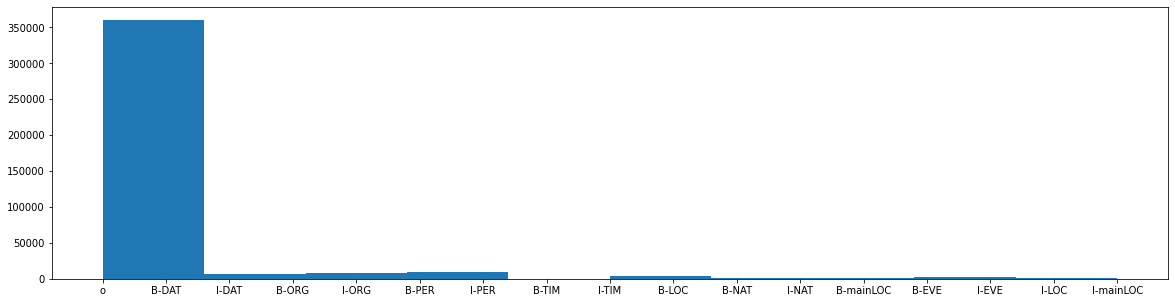

In [11]:
import matplotlib.pyplot as plt
labels_dist = []
for item in data_train['labels']:
    labels_dist = labels_dist + item

plt.figure(figsize=(20,5))
plt.hist(labels_dist, )

In [12]:
labels, counts=np.unique(np.array(labels_dist),return_counts=True)
counts = np.sum(counts) / counts
label_counts = {}
for label, count in zip(labels,counts):
    label_counts[label] = float(count)
label_counts 

{'B-DAT': 273.85843793584377,
 'B-EVE': 508.69559585492226,
 'B-LOC': 132.4495784148398,
 'B-NAT': 656.7107023411371,
 'B-ORG': 84.96603202077023,
 'B-PER': 90.9478925428439,
 'B-TIM': 1700.0562770562772,
 'B-mainLOC': 837.3411513859276,
 'I-DAT': 210.23179871520344,
 'I-EVE': 232.0998817966903,
 'I-LOC': 268.24658469945354,
 'I-NAT': 2618.0866666666666,
 'I-ORG': 52.36871582877717,
 'I-PER': 77.45818540433925,
 'I-TIM': 1428.0472727272727,
 'I-mainLOC': 1428.0472727272727,
 'o': 1.0938745609466005}

In [13]:
list(label_counts.values())

[273.85843793584377,
 508.69559585492226,
 132.4495784148398,
 656.7107023411371,
 84.96603202077023,
 90.9478925428439,
 1700.0562770562772,
 837.3411513859276,
 210.23179871520344,
 232.0998817966903,
 268.24658469945354,
 2618.0866666666666,
 52.36871582877717,
 77.45818540433925,
 1428.0472727272727,
 1428.0472727272727,
 1.0938745609466005]

In [14]:

from datasets import Dataset
dataset_train = Dataset.from_pandas(data_train)
dataset_val = Dataset.from_pandas(data_val)
dataset_test = Dataset.from_pandas(data_test)

### new Way

In [15]:
labels = ["B-DAT", "B-TIM", "B-PER", "B-ORG", "B-LOC", "B-EVE", "B-NAT", "B-mainLOC", "I-DAT", "I-TIM", "I-PER", "I-ORG", "I-LOC", "I-EVE", "I-NAT", "I-mainLOC", "o"]
id2label = {}
label2id = {}
for i, item in enumerate(labels):
    id2label[i] = item
    label2id[item] = i
id2label

{0: 'B-DAT',
 1: 'B-TIM',
 2: 'B-PER',
 3: 'B-ORG',
 4: 'B-LOC',
 5: 'B-EVE',
 6: 'B-NAT',
 7: 'B-mainLOC',
 8: 'I-DAT',
 9: 'I-TIM',
 10: 'I-PER',
 11: 'I-ORG',
 12: 'I-LOC',
 13: 'I-EVE',
 14: 'I-NAT',
 15: 'I-mainLOC',
 16: 'o'}

In [16]:
batch_size = 256
task = "ner" 
model_name = 'HooshvareLab/bert-fa-zwnj-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [17]:
def tokenize_and_align_labels(examples):
    label_all_tokens = True
    tokenized_inputs = tokenizer(list(examples["token"]), padding="max_length",max_length= 128, truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples['labels']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif label[word_idx] == '0':
                label_ids.append(0)
            elif word_idx != previous_word_idx:
                label_ids.append(label2id[label[word_idx]])
            else:
                label_ids.append(label2id[label[word_idx]] if label_all_tokens else -100)
            previous_word_idx = word_idx
        labels.append(label_ids)
        
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [18]:
dataset_test_tokenized=dataset_test.map(tokenize_and_align_labels,batched=True)
dataset_val_tokenized = dataset_val.map(tokenize_and_align_labels,batched=True)
dataset_train_tokenized = dataset_train.map(tokenize_and_align_labels,batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

In [19]:
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(id2label))
model.config.id2label = id2label
model.config.label2id = label2id
model.config._num_labels = len(id2label)
model.config.num_labels = len(label2id)
model

Some weights of the model checkpoint at HooshvareLab/bert-fa-zwnj-base were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-zwnj-

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(42000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [20]:
# you should freeze all parameters except classifier
# otherwise, you will be training the BERT!!
#for param in model.bert.parameters():
#    param.requires_grad = False

batch_size = 32

args = TrainingArguments(
    f"test-{task}",
    evaluation_strategy = "epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    weight_decay=1e-5,
)

In [21]:
data_collator = DataCollatorForTokenClassification(tokenizer)
metric = load_metric("seqeval")

In [22]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [[labels[p] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]
    true_labels = [[labels[l] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {"precision": results["overall_precision"], "recall": results["overall_recall"], "f1": results["overall_f1"], "accuracy": results["overall_accuracy"]}
    

In [23]:
from torch import nn
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(list(label_counts.values()), device="cuda"))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [24]:
trainer = CustomTrainer(
    model,
    args,
    train_dataset=dataset_train_tokenized,
    eval_dataset= dataset_val_tokenized,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: token. If token are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4050
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1270


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.552831,0.091814,0.275401,0.137716,0.656153
2,No log,0.623176,0.106481,0.307487,0.158184,0.661029
3,No log,0.786838,0.135434,0.354278,0.195958,0.723075
4,0.259300,0.991410,0.148890,0.364528,0.211424,0.747510


The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: token. If token are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 225
  Batch size = 32
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [-100    2   10   10   10   10   10   10   10   10   10   16   16   16
    4   16    4   16   16   16   16   16   16   16   16   16    4   12
   16   16   16   16   16   16   16   16   16   16    3   16   16   16
   16   16   16   16   16   16   16   16   16    3    3   16   16   16
   16   16   16   16   16   16   16   16   16   16   16   16   16   16
   16   16   16   16   16   16   16   16   16   16   16   16   16   16
   16   16   16   16   16   16   16   16   16   16   16   16   16   16
   16   16   16   16   16   16   16   16   16   16   16   16   16   16
   16 -100 -10

In [ ]:
trainer.evaluate()

In [ ]:
trainer.save_model('un-ner.model')

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('./un-ner.model/')

In [ ]:
import torch
paragraph = '''مدیرکل محیط سازمان زیست استان البرز با بیان اینکه با بیان اینکه موضوع شیرها به های زباله های انتقال یافته در منطقه موقعیت حلقه موقعیت دره موقعیت خطری برای این استان است ، گفت : در این مورد گزارشاتی در ۲۵تاریخ مردادتاریخ ۱۳۹۷تاریخ تقدیم مدیران استان شده است .'''
tokens = tokenizer(paragraph)
torch.tensor(tokens['input_ids']).unsqueeze(0).size()

In [ ]:
model = AutoModelForTokenClassification.from_pretrained('./un-ner.model/')
predictions = model.forward(input_ids=torch.tensor(tokens['input_ids']).unsqueeze(0), attention_mask=torch.tensor(tokens['attention_mask']).unsqueeze(0))
predictions = torch.argmax(predictions.logits.squeeze(), axis=1)
predictions = [labels[i] for i in predictions]

In [ ]:
words = tokenizer.batch_decode(tokens['input_ids'])
pd.DataFrame({'ner': predictions, 'words': words}).to_csv('un_ner.csv')

In [ ]:
answers = pd.read_csv('./un_ner.csv')
answers